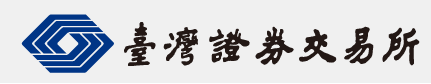

https://www.finlab.tw/Python-%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E5%AF%A6%E4%BD%9C%EF%BC%81/

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np

def crawl_price(date):
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + str(date).split(' ')[0].replace('-','') + '&type=ALL')
    ret = pd.read_csv(StringIO("\n".join([i.translate({ord(c): None for c in ' '}) 
                                        for i in r.text.split('\n') 
                                        if len(i.split('",')) == 17 and i[0] != '='])), header=0)
    ret = ret.set_index('證券代號')
    ret['成交金額'] = ret['成交金額'].str.replace(',','')
    ret['成交股數'] = ret['成交股數'].str.replace(',','')
    return ret

呼叫每日爬蟲，連續爬 n 天
接下來我們就來利用這個 function 幫我們爬最近9天的資料，並將數據存在 data 這個 variable 中：

一次爬 n_days 天的股價

大部分的天數都是 success 代表成功讀取資料，但是每間隔5天就會顯示兩次 fail，代表那可能是假日，然而不能保證就是了，也可能是你的網路斷掉XD，或是 code 有bug，就要單獨做測試，至少在我的電腦裡，它抓的滿好的。

In [2]:
import datetime
import time

data = {}
n_days = 9
date = datetime.datetime.now()
fail_count = 0
allow_continuous_fail_count = 5
while len(data) < n_days:

    print('parsing', date)
    # 使用 crawPrice 爬資料
    try:
        # 抓資料
        data[date.date()] = crawl_price(date)
        print('success!')
        fail_count = 0
    except:
        # 假日爬不到
        print('fail! check the date is holiday')
        fail_count += 1
        if fail_count == allow_continuous_fail_count:
            raise
            break
    
    # 減一天
    date -= datetime.timedelta(days=1)
    time.sleep(10)

parsing 2020-08-14 14:31:10.924595
success!
parsing 2020-08-13 14:31:10.924595
success!
parsing 2020-08-12 14:31:10.924595
success!
parsing 2020-08-11 14:31:10.924595
success!
parsing 2020-08-10 14:31:10.924595
success!
parsing 2020-08-09 14:31:10.924595
fail! check the date is holiday
parsing 2020-08-08 14:31:10.924595
fail! check the date is holiday
parsing 2020-08-07 14:31:10.924595
success!
parsing 2020-08-06 14:31:10.924595
success!
parsing 2020-08-05 14:31:10.924595
success!
parsing 2020-08-04 14:31:10.924595
success!


In [3]:
data

{datetime.date(2020, 8, 14):        證券名稱      成交股數    成交筆數        成交金額     開盤價     最高價    最低價    收盤價  \
 證券代號                                                                      
 1101     台泥  36156000  14,313  1532307850   41.30   43.00  41.25  42.85   
 1101B  台泥乙特      4000       4      213000   53.10   53.30  53.10  53.30   
 1102     亞泥   6329000   2,720   262484550   40.80   41.75  40.80  41.50   
 1103     嘉泥    873000     288    14372500   16.30   16.60  16.30  16.55   
 1104     環泥    737000     383    13413550   18.15   18.30  18.10  18.25   
 ...     ...       ...     ...         ...     ...     ...    ...    ...   
 9944     新麗   2903000   1,288    64225200   21.55   22.95  21.35  22.35   
 9945    潤泰新   6281000   2,999   332699500   52.60   53.40  52.30  53.10   
 9946   三發地產    181000      81     3205650   17.70   17.80  17.60  17.75   
 9955     佳龍    394000     225     7476100   19.10   19.10  18.75  19.05   
 9958    世紀鋼   8017000   5,249   799425000  100.00  102.00  

整理 data 轉成 收盤價 time series
接下來我們來看一下得到了什麼：

In [4]:
data[datetime.date(2020,8,14)]

,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Unnamed: 16
證券代號,,,,,,,,,,,,,,,,
1101,台泥,36156000,"14,313",1532307850,41.30,43.00,41.25,42.85,+,1.65,42.80,170,42.85,60,10.11,NaN
1101B,台泥乙特,4000,4,213000,53.10,53.30,53.10,53.30,NaN,0.00,53.10,1,53.30,19,0.00,NaN
1102,亞泥,6329000,"2,720",262484550,40.80,41.75,40.80,41.50,+,0.40,41.50,456,41.55,10,9.14,NaN
1103,嘉泥,873000,288,14372500,16.30,16.60,16.30,16.55,+,0.20,16.55,29,16.60,100,11.11,NaN
1104,環泥,737000,383,13413550,18.15,18.30,18.10,18.25,+,0.20,18.25,20,18.30,74,10.31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,新麗,2903000,"1,288",64225200,21.55,22.95,21.35,22.35,+,1.10,22.35,42,22.45,23,0.00,NaN
9945,潤泰新,6281000,"2,999",332699500,52.60,53.40,52.30,53.10,-,0.30,53.10,70,53.20,136,7.10,NaN
9946,三發地產,181000,81,3205650,17.70,17.80,17.60,17.75,-,0.05,17.75,8,17.80,22,6.38,NaN


不同的日期，可以得到不同的表。但這並不是我們想要的，我們想要有 time series，也就是看到某個欄位隨時間變動的圖表，於是我們做以下的轉換：

在下面的程式中，現在我們只拿所有股票的 收盤價，並建構 close 這個 dataframe

In [5]:
close = pd.DataFrame({k:d['收盤價'] for k,d in data.items()}).transpose()
close.index = pd.to_datetime(close.index)
close

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,42.85,53.30,41.50,16.55,18.25,10.25,18.00,16.20,20.60,30.10,...,29.75,114.50,54.00,63.90,64.90,22.35,53.10,17.75,19.05,98.50
2020-08-13,41.20,53.30,41.10,16.35,18.05,9.97,17.25,16.10,20.60,30.15,...,30.10,113.00,54.00,63.80,64.50,21.25,53.40,17.80,18.75,99.40
2020-08-12,41.00,53.20,40.75,16.40,17.70,9.96,17.20,16.10,20.05,30.25,...,30.10,110.00,53.80,63.80,64.90,21.90,53.00,17.95,19.35,98.20
2020-08-11,46.50,54.90,40.95,16.45,17.20,9.97,17.15,16.05,19.90,30.20,...,30.10,109.00,53.90,63.90,65.00,22.15,52.70,18.00,19.65,99.10
2020-08-10,46.60,55.00,41.20,16.50,17.15,9.93,17.15,16.40,20.10,30.35,...,30.05,107.00,53.90,63.70,65.00,22.45,53.30,18.40,20.55,98.40
2020-08-07,47.10,54.70,41.05,16.45,17.05,9.71,17.20,16.10,20.00,30.40,...,29.60,106.00,53.80,63.60,65.10,22.80,53.00,18.35,21.75,100.00
2020-08-06,47.15,55.00,41.05,16.65,17.25,9.76,17.15,16.05,20.05,30.40,...,29.65,106.00,53.80,63.70,65.50,23.85,53.40,18.35,20.90,93.70
2020-08-05,46.45,55.10,40.85,16.60,17.20,9.79,17.15,16.30,20.10,29.95,...,29.95,105.50,53.80,63.80,65.40,21.95,53.00,18.10,21.15,93.60
2020-08-04,45.40,55.00,40.45,16.35,17.00,9.55,17.10,16.30,20.15,29.95,...,29.95,104.50,53.90,63.60,65.40,21.55,52.20,18.00,20.70,94.00
